# Setup

In [41]:
# settings
import scanpy_helpers
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline
reload(scanpy_helpers) # force module import during dev

# download data from s3
wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data'
s3dir = 'daniel.le-work/MEL_project'
for file in ['primary_mel_rawdata_181011.csv','primary_mel_metadata_181011.csv']:
    ! aws s3 cp --quiet s3://{s3dir}/{file} {wkdir}/

# read raw data (expression data) to pandas df
pre_adata = pd.read_csv('{}/primary_mel_rawdata_181011.csv'.format(wkdir))

# read annotation data
anno = pd.read_csv('{}/primary_mel_metadata_181011.csv'.format(wkdir))

scanpy version: 1.3.2+78.g5034872


# Ingest data protocol
- Raw data and annotation CSV provided by Ashley Maynard
- Append gene marker expression
- Subsequently, ERCC-associated gene names are removed.

In [2]:
raw_adata = create_adata(pre_adata)
anno_dict = {'age':'age',
             'plate':'plate',
             'location':'Anatomical_location',
             'race':'Race',
             'sex':'Sex',
             'color':'sample_color',
             'patient':'patient_id'}
append_anno(raw_adata, anno, anno_dict)
append_markers(raw_adata, gene_markers=['PMEL','KRT1','KRT5','KRT10','TYR','MITF','HRH2'])
raw_adata = remove_ercc(raw_adata) 

Ingest raw data...
	Cells: 4356, Genes: 26485
Append annotations...
	Cells: 4356, Genes: 26485
Append marker gene expresssion...
Remove ERCC genes...
Filtered genes: 11
	Cells: 4356, Genes: 26474


# Global expression statistics
- Analysis read count and gene coverage 

            n_genes   n_count  med_count
n_genes    1.000000  0.058316  -0.198644
n_count    0.058316  1.000000   0.688347
med_count -0.198644  0.688347   1.000000


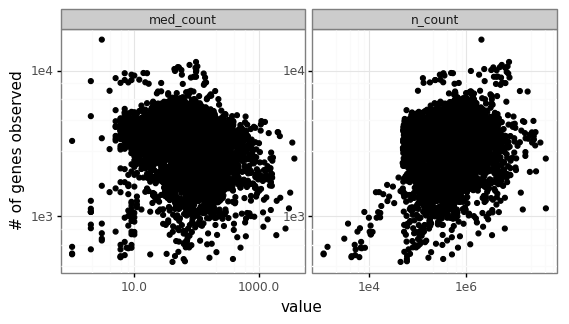

<ggplot: (-9223363302461053310)>

In [14]:
# Determine degree of expression level explained by genes (count>0) per cell
    # sum of counts as proxy for overall cell expression level
    
n_genes = pre_adata.iloc[:,1:].apply(lambda x: x>0).sum()
med_count = pre_adata.iloc[:,1:].replace(0, np.nan).median() # non-zero median
n_count = pre_adata.iloc[:,1:].sum()

df = pd.DataFrame({'n_genes':n_genes,'n_count':n_count, 'med_count':med_count})
print(df.corr())

plot_df = pd.melt(df, id_vars='n_genes')
(ggplot(plot_df, aes('value','n_genes'))+
    theme_bw()+
    theme(aspect_ratio=1)+
    geom_point()+
    scale_x_log10()+
    scale_y_log10()+
    facet_wrap('~variable', nrow=1, scales='free')+
    labs(y='# of genes observed'))

# Cohort analysis
- Determine general statistics
- Determine feature class statistics

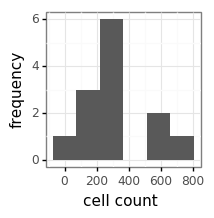

<ggplot: (-9223363302460655886)>


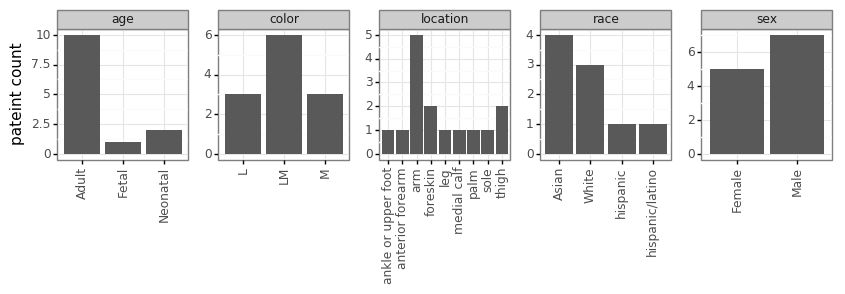

<ggplot: (8734394129114)>


In [15]:
input_data = raw_adata

# Cell distribution among patients
plot_data = list(input_data.obs.groupby('patient').count()['count_idx'])
df = pd.DataFrame({'counts':plot_data})

plotnine.options.figure_size = (2,2)
print(ggplot(df, aes(x='counts'))+
     theme_bw() +
     theme(aspect_ratio=1)+
    geom_histogram()+
    labs(x='cell count', y='frequency'))

# Patient distribution among classes
count_list = []
label_list = []
group_list = []
for feat in ['age','color','sex','race','location']:
    count_list = count_list + input_data.obs.groupby(by=feat).nunique()['patient'].values.tolist()
    labels = input_data.obs.groupby(by=feat).nunique().index.tolist()
    label_list = label_list + labels
    group_list = group_list + [feat for x in range(len(labels))]
df = pd.DataFrame({'group':group_list,'key':label_list,'count':count_list})

plotnine.options.figure_size = (10, 10)
print(ggplot(df, aes('key','count'))+
     theme_bw() +
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90),
          panel_spacing_x=0.3) +
    geom_bar(stat='identity', position='dodge') +
    facet_wrap('~group', scales='free', nrow = 1) +
    labs(y='pateint count', x=''))

# All-cells analysis
- Filter cells/genes: min-reads, min-genes, and dispersion range
- Scale/transform expression values
- PCA dimensionality reduction
- Cluster by diffusion-like random walk
- Louvain community detection
- UMAP plot

Process expression data...
	Initial values:
	Cells: 4356, Genes: 26474
min counts per cell(min_counts): 50000
min genes per cell(min_genes): 500
min expression dispersion(min_disp): 0.1
min mean expression(min_mean): 0.001
max mean expression(max_mean): 1000.0
Filtered cells: 45
Filtered genes: 15764
	Final values:
	Cells: 4311, Genes: 10710
Principle component analysis...


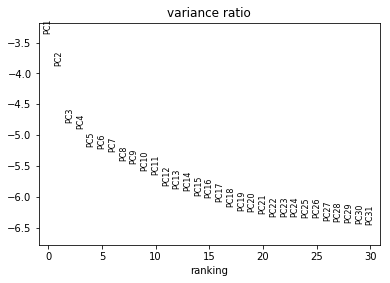

Enter number of principle components to use:
20
principle_components(num_pcs): 20
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


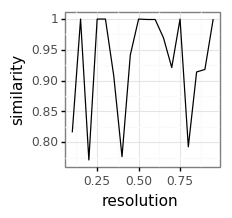

<ggplot: (8734394834724)>
Enter Louvain detection resolution to use:
0.8
resolution(res): 0.8
... storing 'age' as categorical
... storing 'plate' as categorical
... storing 'location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


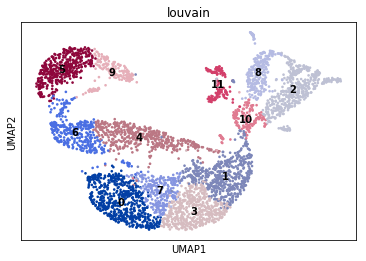

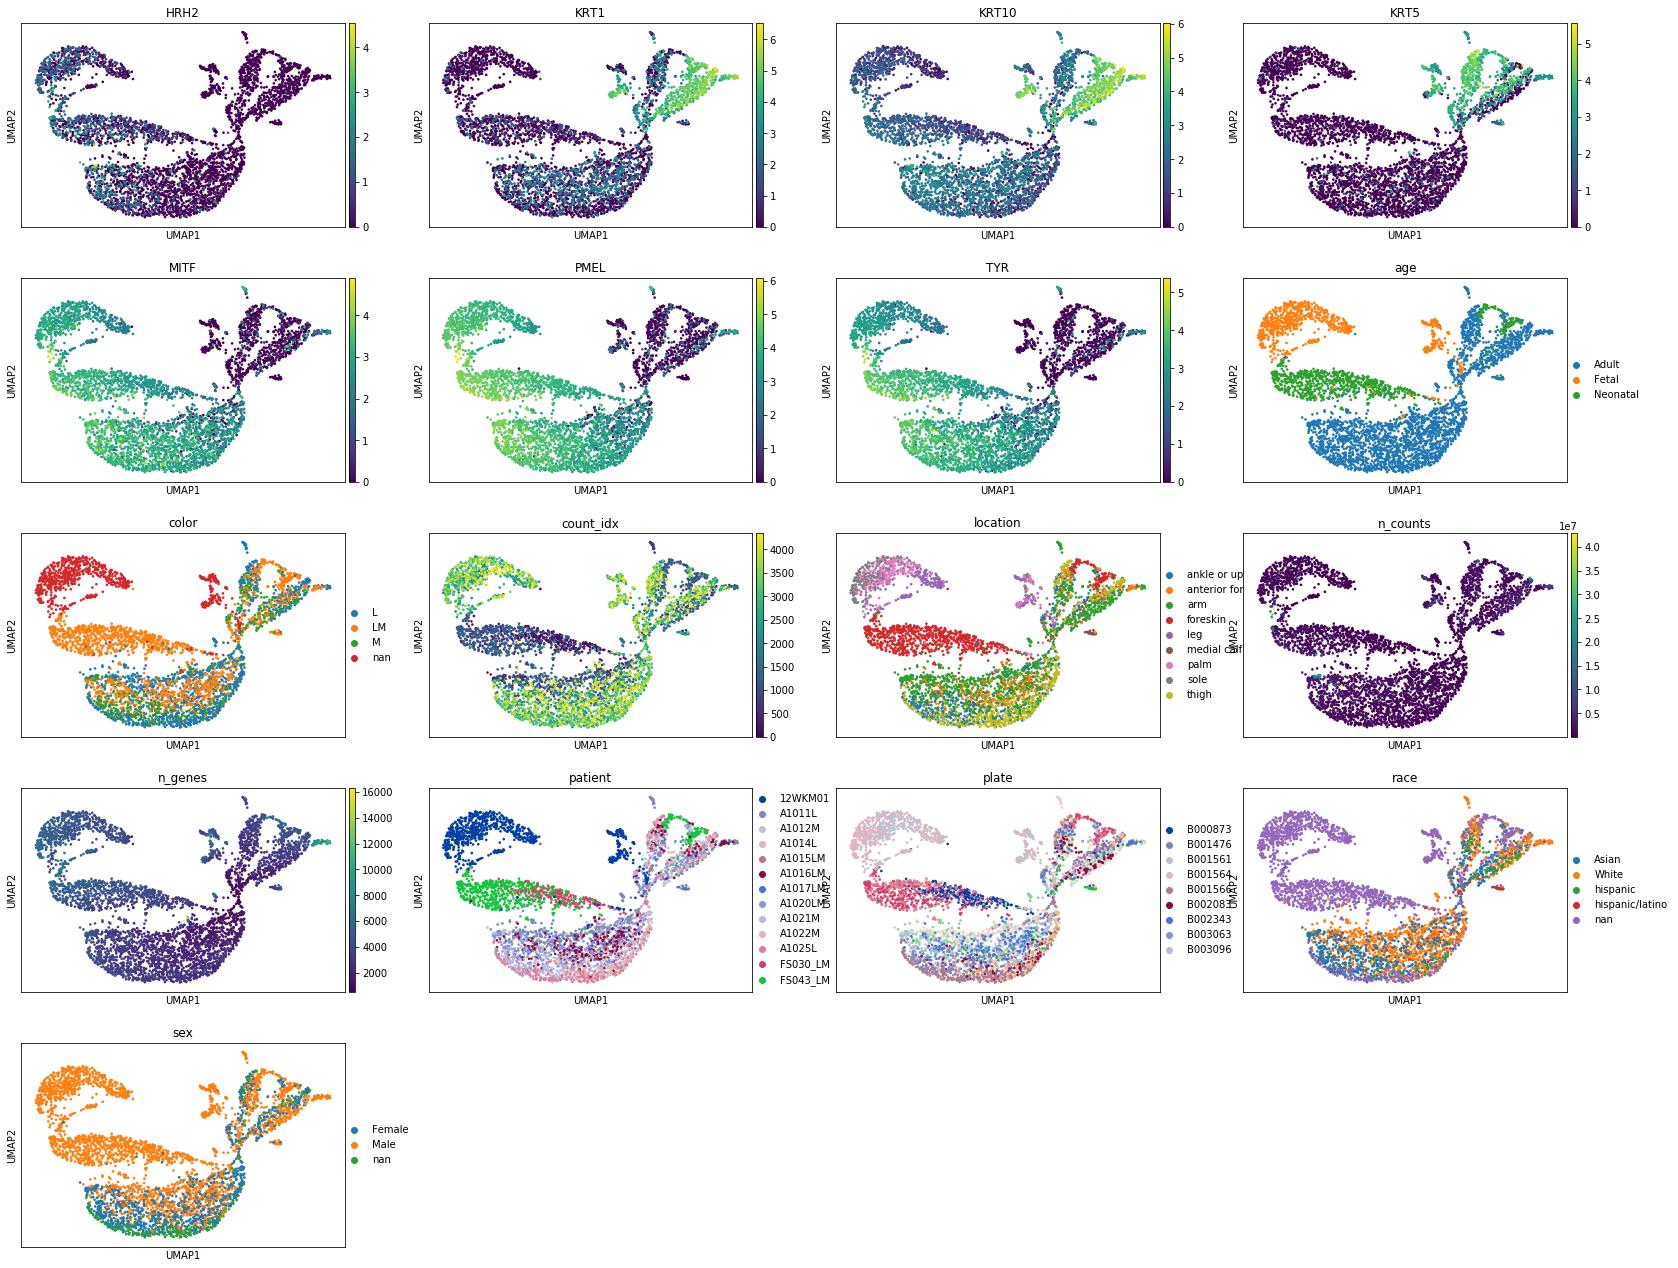

In [16]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata)
umap_adata(full_adata)

# Classify MEL vs KRT
- Manual classification based on marker gene expression

In [17]:
# create list of louvain cluster for each cell label
KRT_int = [2,8,10,11]
MEL_int = [0,1,3,4,5,6,7,9]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}

# DUB_int = [9]
# type_dict = {'KRT':[str(x) for x in KRT_int],
#              'MEL':[str(x) for x in MEL_int],
#              'DUB':[str(x) for x in DUB_int]}
    
classify_type(raw_adata, full_adata, type_dict)

# Subset and re-analyze
- Subset filter based on categorical clinical metadata and assigned cluster: age, location, race, sex, ratio_label, color, patient, louvain

['A1011L', 'A1012M', 'A1014L', 'A1015LM', 'A1016LM', 'A1017LM', 'A1020LM', 'A1021M', 'A1022M', 'A1025L']
Subsetting data...
key = type, value = MEL, matched = 3273
key = patient, value = A1025L, matched = 319
	Cells: 243, Genes: 26474
Process expression data...
	Initial values:
	Cells: 243, Genes: 26474
min counts per cell(min_counts): 50000
min genes per cell(min_genes): 500
min expression dispersion(min_disp): 0.1
min mean expression(min_mean): 0.001
max mean expression(max_mean): 1000.0
Filtered cells: 0
Filtered genes: 19506
	Final values:
	Cells: 243, Genes: 6968
Principle component analysis...


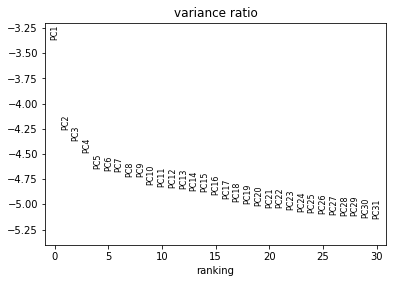

Enter number of principle components to use:
30
principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


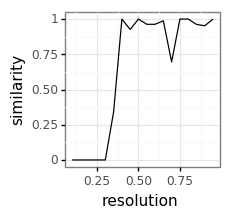

<ggplot: (-9223363302454025419)>
Enter Louvain detection resolution to use:
0.7
resolution(res): 0.7
... storing 'age' as categorical
... storing 'plate' as categorical
... storing 'location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'type' as categorical


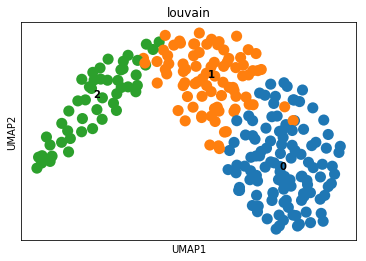

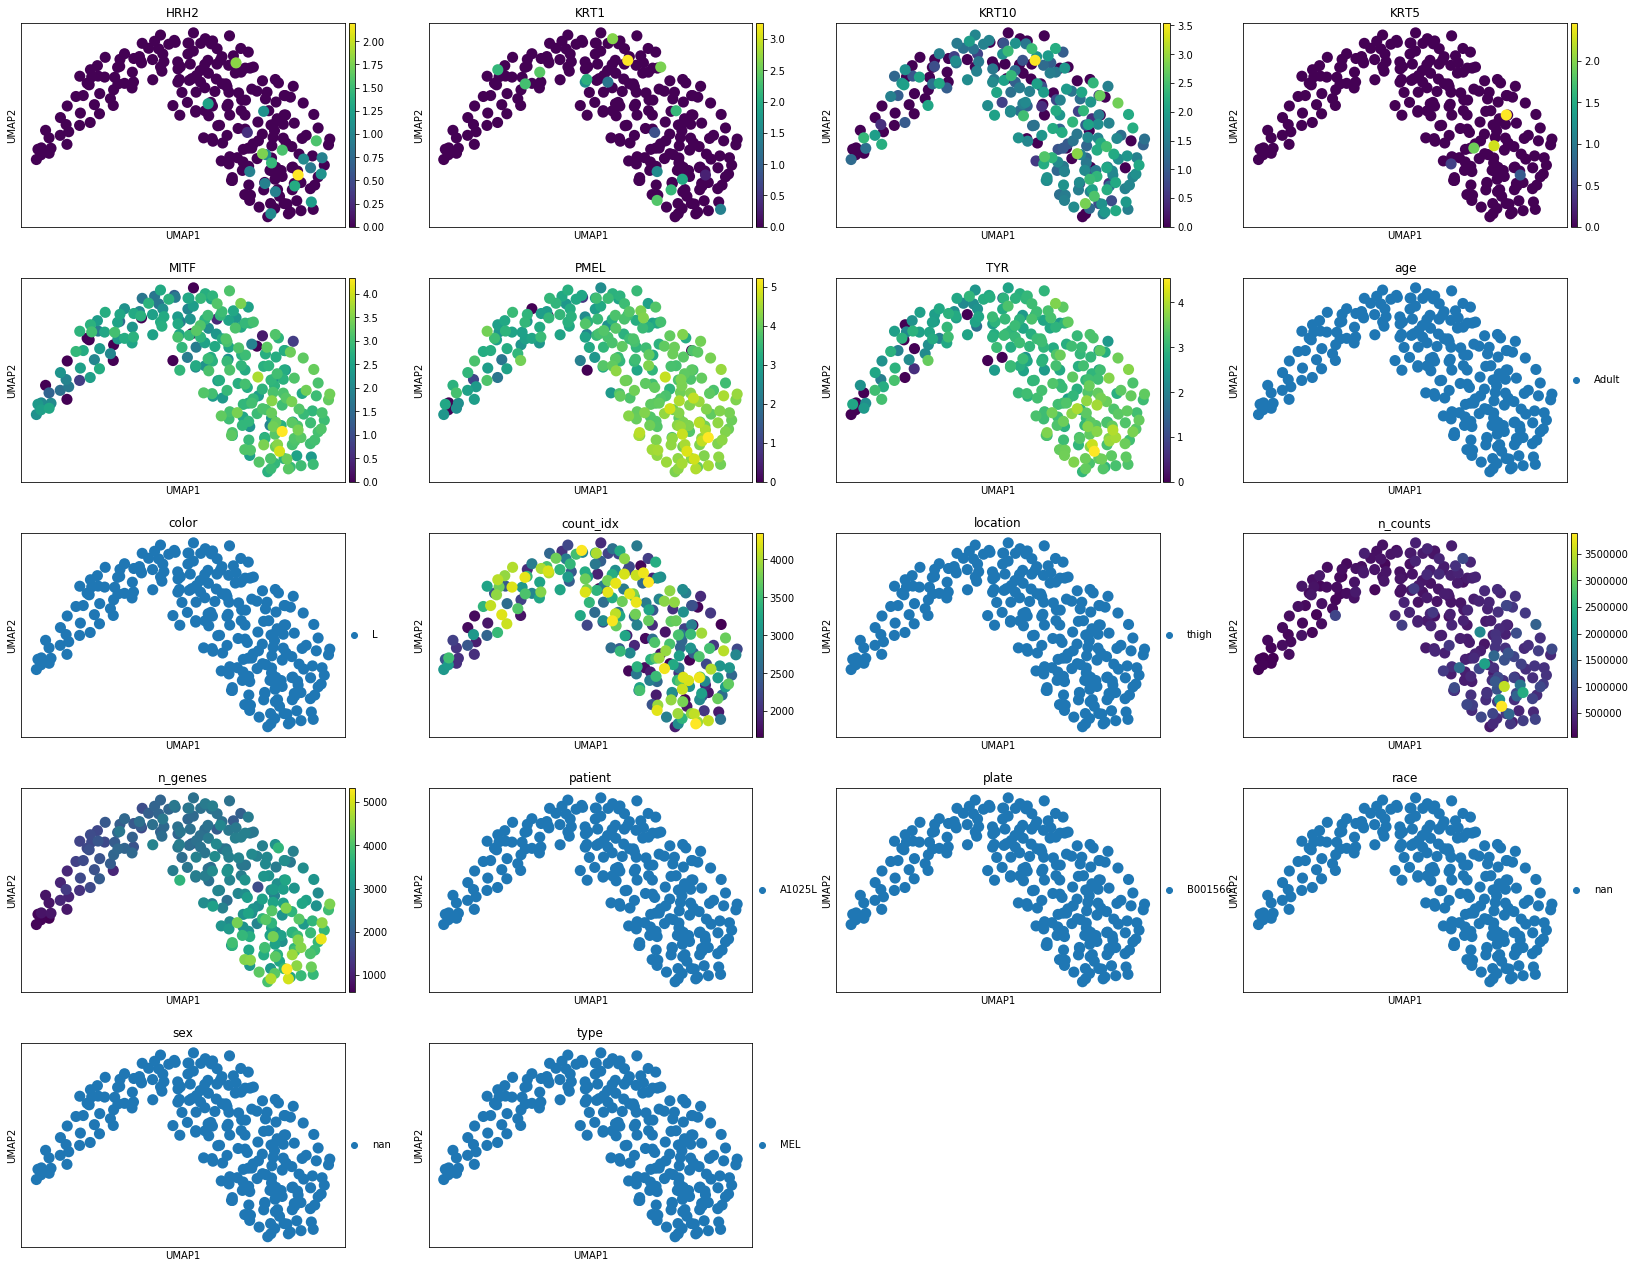

In [67]:
print(raw_adata[raw_adata.obs['age'] == 'Adult'].obs.groupby('patient').nunique().index.tolist())

feature_dict = {'type':['MEL'], 'patient':['A1025L']}
adata_subset = subset_adata(raw_adata, feature_dict)
adata_subset = process_adata(adata_subset)
pca_adata(adata_subset)
umap_adata(adata_subset)

# Differential gene expression rank per cluster
- Rank enriched genes per cluster

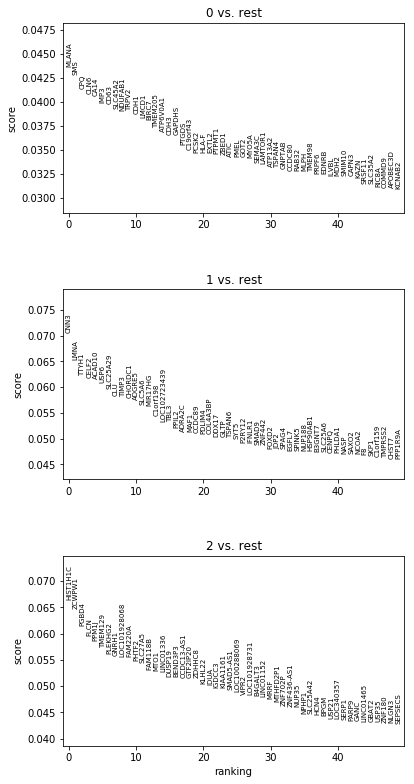

https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/GeneRank_type.MEL_patient.A1025L.csv
         0         1             2
0    MLANA      CNN3      HIST1H1C
1      SMS      LMNA        ZCWPW1
2      CPQ     TTYH1         PGBD4
3     CLN6     CELF2          FLCN
4     CA14    ACAD10         PPM1J
5     IMP3      USP6       TMEM129
6     CD63  SLC25A29       PLEKHG2
7  SLC45A2       CLU         GNRH1
8  NDUFAB1     TIMP3  LOC101928068
9    TRPV2   CHORDC1       FAM220A


In [68]:
rank_genes(adata_subset, feature_dict, wkdir, s3dir)

# Candidate gene contribution to principle components
- PCA loadings are normalized to max PC loading

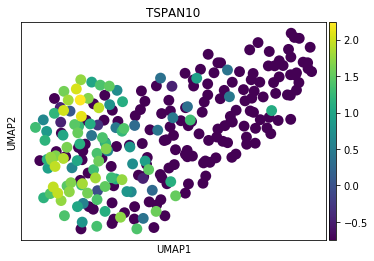

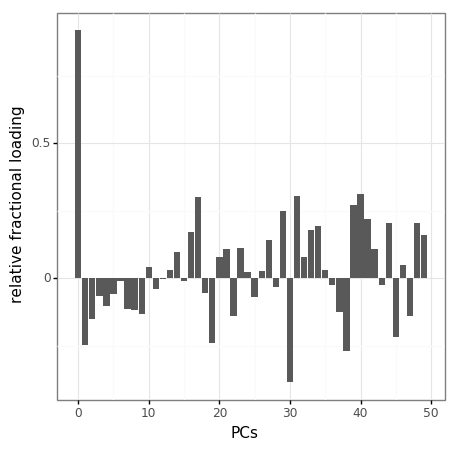

<ggplot: (8734398760077)>


In [63]:
PC_contribution (target='TSPAN10', input_adata=adata_subset)

In [39]:
# Garbage collection
## remove PDF output tmp files
! rm /home/ubuntu/git/biohub_scratch1/output*

rm: cannot remove '/home/ubuntu/git/biohub_scratch1/output*': No such file or directory
